In [1]:
from transformers import (
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
    TrainerCallback,
)
from datasets import load_dataset, Dataset, DatasetDict
import pandas as pd
import torch
import random
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.utils.class_weight import compute_class_weight
import os
import numpy as np
import sys
import matplotlib.pyplot as plt
import yaml
from utils.model_utils import compute_metrics, ReduceLROnPlateauCallback
from datetime import datetime


/home/tommarz/.conda/envs/gnn/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-23 16:55:18.350358: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-23 16:55:19.559403: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
PROJECT_ROOT = os.path.join(os.environ["HOME"], "hate_speech_detection_thesis")
os.environ['PROJECT_ROOT'] = PROJECT_ROOT
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [3]:
project_root = os.getenv('PROJECT_ROOT')
if project_root:
    os.chdir(project_root)
else:
    raise EnvironmentError("PROJECT_ROOT environment variable is not set.")


In [4]:
from utils.utils import set_seed, resolve_placeholders

In [5]:
seed = 0
set_seed(seed)

In [6]:
config_path = os.path.join(os.environ['PROJECT_ROOT'], 'config.yaml')
with open(config_path, 'r') as file:
    config = yaml.safe_load(file)
config = resolve_placeholders(config)

In [7]:
dataset_name = "echo"

In [8]:
data_dir = config["data"]
labeled_posts_file_path = data_dir['post_level_file_template'].format(dataset_name=dataset_name)
labeled_users_file_path = data_dir['user_level_file_template'].format(dataset_name=dataset_name)

print(f"Resolved post-level file path: {labeled_posts_file_path}")
print(f"Resolved user-level file path: {labeled_users_file_path}")

Resolved post-level file path: data/post_level/echo_posts_2_labels.tsv
Resolved user-level file path: data/user_level/echo_users_2_labels.tsv


In [9]:
default_json_path = config['settings']['default_json_path']
user_key = 'user_id'
default_json_path

'splits.json'

In [10]:
from utils.train_test_split import stratified_split

In [11]:
labeled_users_df = pd.read_csv(labeled_users_file_path, sep='\t', index_col=user_key)['label']
labeled_posts_df = pd.read_csv(labeled_posts_file_path, sep='\t')

In [12]:
from sklearn.model_selection import GroupShuffleSplit

In [13]:
def get_train_test_users_df(posts_df, users_df, n_splits=5, test_size=0.2, random_state=seed):
    gsp = GroupShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)
    for train_indices, test_indices in gsp.split(posts_df, groups=posts_df[user_key]):
        train_df, test_df = posts_df.iloc[train_indices], posts_df.iloc[test_indices]
        train_users = train_df[user_key].unique()
        test_users = test_df[user_key].unique()
        train_users_labels = users_df[train_users]
        test_users_labels = users_df[test_users ]
        yield train_df, test_df, train_users_labels, test_users_labels

In [14]:
train_posts_df, test_posts_df, train_users_df, test_users_df = next(get_train_test_users_df(labeled_posts_df, labeled_users_df, n_splits=1, test_size=0.2, random_state=seed))
train_posts_df, val_posts_df, train_users_df, val_users_df = next(get_train_test_users_df(train_posts_df, train_users_df, n_splits=1, test_size=0.1, random_state=seed))

In [15]:
users_stats_df = pd.concat([train_users_df.agg(['mean', 'count']), val_users_df.agg(['mean', 'count']), test_users_df.agg(['mean', 'count'])], axis=1, keys=['train', 'val', 'test'])
posts_stats_df = pd.concat([train_posts_df['label'].agg(['mean', 'count']), val_posts_df['label'].agg(['mean', 'count']), test_posts_df['label'].agg(['mean', 'count'])], axis=1, keys=['train', 'val', 'test'])
display(users_stats_df)
display(posts_stats_df)

,train,val,test
mean,0.142857,0.1875,0.180905
count,714.000000,80.0000,199.000000


,train,val,test
mean,0.099226,0.13278,0.12709
count,2066.000000,241.00000,598.00000


In [16]:
train_users = train_users_df.index.to_list()
val_users = val_users_df.index.tolist()
test_users = test_users_df.index.tolist()

In [17]:
labeled_posts_df["split"] = labeled_posts_df[user_key].apply(
    lambda x: "train" if x in train_users else "val" if x in val_users else "test"
)
labeled_posts_df

,id,user_id,text,label,split
0,7700110248,15858785,@mmmeghan lies. Call me!!!I'm taking a nap.,0,train
1,23123054279,153413422,Ok,0,test
2,9373956897243138,68906938,@daHOMIEjrod i aint into missing out on what i do,0,train
3,13328337611001856,153413422,;),0,test
4,55409490136276992,149236129,@IvankaTrump had a great time with you at @NCS...,0,train
...,...,...,...,...,...
2900,811182239908294656,920083518,(i3+4GB+1TB) ((((R$1390 )))) \nNotebook Dell I...,0,test
2901,811197101187080192,3235695054,"------------&gt; Who ( Built ) the Moon , \n\n...",0,train
2902,811224329107230720,3125373419,@rantytrans be like me and go thrifting!,0,test
2903,811240672086921216,16606038,@JumpVote @WinAngela put Gary Sinise in charge,0,train


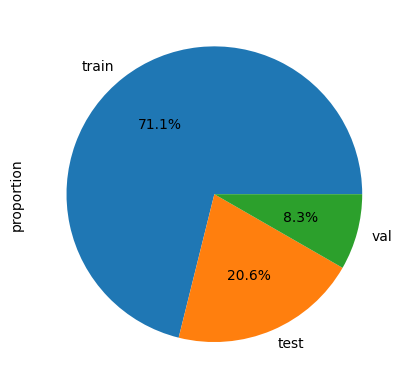

In [18]:
labeled_posts_df["split"].value_counts(normalize=True).plot(
    kind="pie", autopct="%1.1f%%"
)
plt.show()

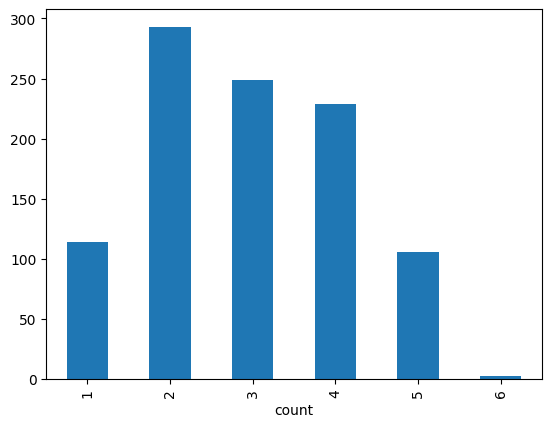

In [19]:
labeled_posts_df[user_key].value_counts().value_counts().sort_index().plot(kind="bar")
plt.show()

In [20]:
# Convert to `datasets` Dataset format
train_dataset = Dataset.from_pandas(train_posts_df.drop(columns=[user_key, "id"]))
val_dataset = Dataset.from_pandas(val_posts_df.drop(columns=[user_key, "id"]))
test_dataset = Dataset.from_pandas(test_posts_df.drop(columns=[user_key, "id"]))

dataset = DatasetDict(
    {"train": train_dataset, "validation": val_dataset, "test": test_dataset}
)

In [21]:
from methods.post_level.fine_tuned_bert import load_and_freeze_model

In [22]:
model_name = "cardiffnlp/twitter-roberta-base-hate-latest"

# tokenizer, base_model = load_and_freeze_model(model_name)

In [23]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [24]:
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=True, max_length=512)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map: 100%|██████████| 598/598 [00:00<00:00, 8959.88 examples/s]


In [25]:
y_train = tokenized_datasets["train"]["label"]
y_val = tokenized_datasets["validation"]["label"]
y_test = tokenized_datasets["test"]["label"]

In [26]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=train_posts_df["label"].unique(), y=train_posts_df["label"])
class_weights = torch.tensor(class_weights, dtype=torch.float32)  

In [27]:
class WeightedLossModel(nn.Module):
    def __init__(self, base_model, class_weights):
        super().__init__()
        self.base_model = base_model
        self.class_weights = class_weights
        self.loss_fn = nn.CrossEntropyLoss(weight=class_weights)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask, labels=None)
        logits = outputs.logits
        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)
        return {'loss': loss, 'logits': logits} if labels is not None else {'logits': logits}


In [28]:
# # Wrap the base model with weighted loss
# model = WeightedLossModel(base_model, class_weights)

In [29]:
# for name, param in model.named_parameters():
#     if "classifier" not in name:
#         param.requires_grad = False

In [30]:
# class MultiLayerClassifier(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim):
#         super(MultiLayerClassifier, self).__init__()
#         self.linear1 = nn.Linear(input_dim, hidden_dim)
#         self.relu = nn.ReLU()
#         self.linear2 = nn.Linear(hidden_dim, output_dim)

#     def forward(self, x):
#         x = self.linear1(x)
#         x = self.relu(x)
#         x = self.linear2(x)
#         return x

# # Define the new classifier
# input_dim = model.classifier.in_features
# hidden_dim = 512  # You can adjust this value
# model.num_labels = 2

# model.classifier = MultiLayerClassifier(input_dim, hidden_dim, model.num_labels)

# # Optional: initialize the weights of the new classifier
# model.classifier.apply(model._init_weights)

In [31]:
# # Verify that only the classification head is trainable
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(name)

In [32]:
# Total parameters
total_params = sum(p.numel() for p in model.parameters())
# Trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total Parameters: {total_params/1e6}M")
print(f"Trainable Parameters: {trainable_params/1e6}M")

Total Parameters: 124.64717M
Trainable Parameters: 124.64717M


In [33]:
output_dir = config['experiments']['post_level_results_dir']
logging_dir = config['experiments']['post_level_logging_dir']

output_dir = os.path.join(
    output_dir, dataset_name, model_name.split("/")[-1], timestamp
)
logging_dir = os.path.join(
   logging_dir, dataset_name, model_name.split("/")[-1], timestamp
)

print(output_dir)
print(logging_dir)

20241223_165524
experiments/post_level/results/echo/twitter-roberta-base-hate-latest/20241223_165524
experiments/post_level/logs/echo/twitter-roberta-base-hate-latest/20241223_165524


In [36]:
bs = 64
num_train_epochs = 5

training_args = TrainingArguments(
    output_dir=output_dir,  # output directory
    eval_strategy="epoch",  # Evaluate during training (or use "epoch")
    save_strategy="epoch",  # Save the model at the end of each epoch,
    logging_strategy="epoch",
    # eval_steps=500,                       # Evaluation and checkpoint every 500 steps
    learning_rate=5e-4,  # Initial learning rate
    per_device_train_batch_size=bs,  # Batch size for training
    per_device_eval_batch_size=bs,  # Batch size for evaluation
    num_train_epochs=num_train_epochs,  # Number of training epochs
    weight_decay=1e-2,                    # Weight decay
    logging_dir=logging_dir,  # Directory for storing logs
    # logging_steps=100,                    # Log every 100 steps
    save_total_limit=1,  # Limit the total number of checkpoints
    load_best_model_at_end=True,  # Load the best model at the end of training
    metric_for_best_model="eval_loss",  # Metric to use for early stopping and saving the best model
    greater_is_better=False,  # Set to False because lower eval_loss is better
)

# Generate current timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

print(timestamp)  # Example: 20241221_143045

20241223_165535


In [37]:
# Add EarlyStoppingCallback to the Trainer
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=2, # Number of evaluations with no improvement after which training stops

)

optimizer = torch.optim.AdamW(model.parameters(), lr=training_args.learning_rate, weight_decay=training_args.weight_decay)

reduce_lr_callback = ReduceLROnPlateauCallback(optimizer, patience=2, factor=0.1, mode='min')

In [38]:
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],  # Train dataset
    eval_dataset=tokenized_datasets["validation"],  # Validation dataset
    callbacks=[early_stopping_callback, reduce_lr_callback],  # Add callbacks
    tokenizer=tokenizer,
    optimizers=(optimizer,None)
)

In [39]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.436100,0.452470
2,0.335400,0.410870
3,0.325300,0.424174
4,0.325100,0.396643


OSError: [Errno 39] Directory not empty: 'experiments/post_level/results/echo/twitter-roberta-base-hate-latest/20241223_165524/checkpoint-132'

In [61]:
model = AutoModelForSequenceClassification.from_pretrained("experiments/post_level/results/echo/twitter-roberta-base-hate-latest/20241223_164844/checkpoint-130")
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],  # Train dataset
    eval_dataset=tokenized_datasets["validation"],  # Validation dataset
    callbacks=[early_stopping_callback, reduce_lr_callback],  # Add callbacks
    tokenizer=tokenizer,
    optimizers=(optimizer,None)
)

In [62]:
model.eval()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [63]:
metrics = trainer.evaluate(tokenized_datasets["train"])
print(metrics)

{'eval_loss': 0.10134506225585938, 'eval_runtime': 2.4137, 'eval_samples_per_second': 855.931, 'eval_steps_per_second': 13.672}


In [64]:
metrics = trainer.evaluate(tokenized_datasets["validation"])
print(metrics)

{'eval_loss': 0.18293514847755432, 'eval_runtime': 0.1401, 'eval_samples_per_second': 1720.616, 'eval_steps_per_second': 28.558}


In [65]:
metrics = trainer.evaluate(tokenized_datasets["test"])
print(metrics)

{'eval_loss': 0.2591050863265991, 'eval_runtime': 0.5957, 'eval_samples_per_second': 1003.844, 'eval_steps_per_second': 16.787}


In [66]:
train_logits = trainer.predict(tokenized_datasets["train"]).predictions
val_logits = trainer.predict(tokenized_datasets["validation"]).predictions
test_logits = trainer.predict(tokenized_datasets["test"]).predictions

In [67]:
# Compute metrics for each split
metrics_train = compute_metrics((train_logits, y_train))
metrics_val = compute_metrics((val_logits, y_val))
metrics_test = compute_metrics((test_logits, y_test))

# Create a dataframe to display the results
metrics_df = pd.DataFrame(
    [metrics_train, metrics_val, metrics_test], index=["train", "validation", "test"]
)
display(metrics_df)

,roc_auc,accuracy,precision,recall,f1
train,0.979777,0.968054,0.875676,0.790244,0.830769
validation,0.964115,0.950207,0.884615,0.718750,0.793103
test,0.921406,0.919732,0.741379,0.565789,0.641791


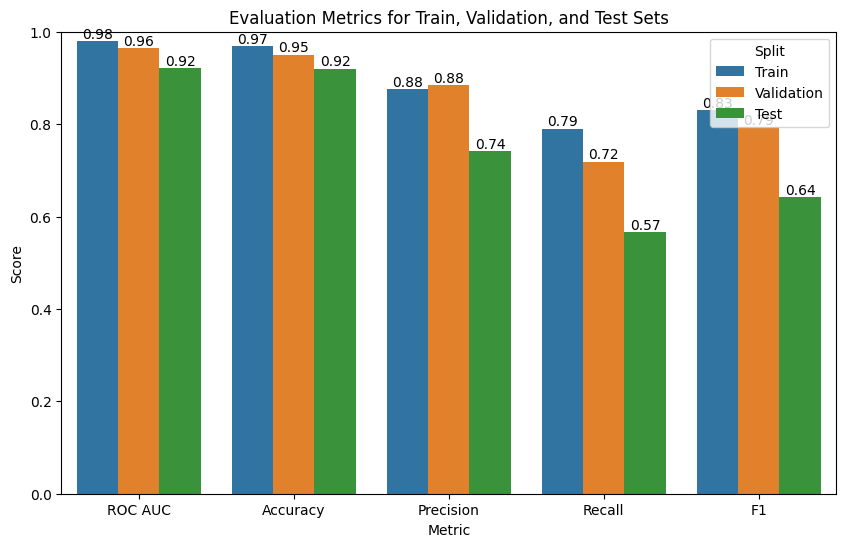

In [68]:
import seaborn as sns

# Convert the metrics dictionary to a DataFrame
metrics_df = pd.DataFrame(
    {
        "Metric": ["ROC AUC", "Accuracy", "Precision", "Recall", "F1"],
        "Train": [
            metrics_train["roc_auc"],
            metrics_train["accuracy"],
            metrics_train["precision"],
            metrics_train["recall"],
            metrics_train["f1"],
        ],
        "Validation": [
            metrics_val["roc_auc"],
            metrics_val["accuracy"],
            metrics_val["precision"],
            metrics_val["recall"],
            metrics_val["f1"],
        ],
        "Test": [
            metrics_test["roc_auc"],
            metrics_test["accuracy"],
            metrics_test["precision"],
            metrics_test["recall"],
            metrics_test["f1"],
        ],
    }
)

# Melt the DataFrame for seaborn
metrics_melted_df = metrics_df.melt(
    id_vars="Metric", var_name="Split", value_name="Score"
)

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x="Metric", y="Score", hue="Split", data=metrics_melted_df)
plt.xlabel("Metric")
plt.ylabel("Score")
plt.title("Evaluation Metrics for Train, Validation, and Test Sets")
plt.ylim(0, 1)
# Add bar labels
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt="%.2f")

plt.show()

In [1]:
model_dir = "experiments/post_level/results/echo/finetuned_twitter_hate_speech_roberta/20241223_145105/checkpoint-230"
users_tweets_json = "/home/tommarz/hate_speech_detection_thesis/echo_posts_per_user.json"

In [ ]:
import json
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from tqdm import tqdm
import pandas as pd
import os
import numpy as np

In [ ]:

# Load the JSON data
with open(users_tweets_json, 'r') as f:
    users_tweets = json.load(f)

In [ ]:
# Flatten the JSON data and construct a DataFrame
tweets_data = []
for user, tweets in tqdm(users_tweets.items()):
    for tweet in tweets:
        tweet_data = {
            'user_id': user,
            'timestamp': tweet[0],
            'tweet_id': tweet[1],
            'text': tweet[2]
        }
        tweets_data.append(tweet_data)
tweets_df = pd.DataFrame(tweets_data)
tweets_df

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [33]:
def load_model(model_dir):
    tokenizer = AutoTokenizer.from_pretrained(model_dir)
    model = AutoModelForSequenceClassification.from_pretrained(model_dir)
    return tokenizer, model

def predict_batch(model, tokenizer, texts):
    inputs = tokenizer(texts, return_tensors="pt", truncation=True, padding=True).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    return predictions.tolist()

In [ ]:
tokenizer, model = load_model(model_dir)
model.to(device)

In [38]:
# Function to make predictions for each user
def predict_for_users(users_tweets, tokenizer, model):
    user_predictions = {}
    for uid, g in tqdm(users_tweets.groupby('user_id')):
        texts = g['text'].values.tolist()
        predictions = predict_batch(model, tokenizer, texts)
        user_predictions[uid] = predictions
    return user_predictions

In [ ]:
user_predictions = predict_for_users(tweets_df, tokenizer, model)

In [ ]:
list(user_predictions.keys())[0]

In [ ]:
# Make predictions for each user
user_predictions = predict_for_users(tweets_df, tokenizer, model)
user_predictions

In [ ]:

predictions = predict_for_all_users(model_dir, users_tweets_json)

with open("predictions.json", "w") as f:
    json.dump(predictions, f, indent=4)

# Graph

In [43]:
from preprocessing.create_graph import create_weighted_multigraph

In [ ]:
edgelist = pd.read_csv("data/network_level/echo/social_interactions.tsv", sep='\t')